#### NF Files: lectura de archivos y preparación del input para la U-net

**Contenidos** 

0. [Dependencias y espacio de trabajo](#id0)
1. [Testeo superficial de los datos](#id1)
2. [Reproyección GFS](#id2)
3. [Preprocesamiento de los datos](#id3)
    - 3.1 [Importación de los datos](#id4)
    - 3.2 [Cargado de valores](#id5)
    - 3.3 [Estandarización de valores](#id6)
    - 3.4 [Extracción de parches](#id7)
        - 3.4.1 [Parches GFS y ERA5](#id8)
        - 3.4.2 [Parches DEM](#id9)
        - 3.4.3 [Parches Latitud](#id10)
        - 3.4.4 [Parches Longitud](#id11)
        - 3.4.5 [Parches Time](#id12)
        - 3.4.6 [Resumen Parches](#id13)
    - 3.5 [Normalización](#id14)
    - 3.6 [Revisión de parches](#id15)
    - 3.7 [División de la data](#id16)
    - 3.8 [Ajuste variable Time](#id17)
4. [Entrenamiento U-net](#id18)
5. Excepciones a atender: 
    - 5.1 [Sobre el solapamiento de GFS](#ex1)
    - 5.3 [Sobre la variable *time*](#ex3)


### 0. [Dependencias y espacio de trabajo] <div id='id0'>

- Entorno conda: 

```conda create -n <nombre_env> python=3.10.4```
- dependencias

| Librería | Versión | Método |
|----------|---------| ------ |
| ipykernel | -- | pip |
| matplotlib | 3.6.2 | pip
| tensorflow | 2.11.0      | pip 
| xarray   |  2022.11.0 | pip
| dask | 2022.5.0 | pip
| cfgrib | 0.9.10.3 | pip
| scipy | 1.9.3 |  pip
| netcdf4 | 1.6.2 | pip
| h5netcdf | 1.1.0 | pip
| tqdm | 4.64.1 | pip 
| jinja2 |  3.1.2  | pip

Nota 1: En caso de error con la importación del paquete *cfgrib*, se debe tipear la siguiente linea que complementará la instalación del paquete *cfgrib*:

```conda install -c conda-forge eccodes```

Nota 2: La versión de *eccodes* utilizada es la 1.5.0

### 1. Testeo superficial de los datos <div id='id1'>

In [1]:
import tensorflow as tf
import rioxarray as rxr
from tqdm import tqdm 
import xarray as xr 
import numpy as np 
import glob
import os 
import re

Ejemplo archivo GFS 0.5 (input): 

|Atr.| Datos      | 
|-----|------|
| Año | 2022 | 
| Mes | 01   |  
| Día | 01   | 
| Fuente| Khipu| 

In [2]:
g05_og = xr.open_dataset("../Datos/GFS/2022/2022010100/GFS0.5_t2m_heightAboveGround_instant_2022010100.nc")
g05_og

c:\Users\LENOVO i7\Anaconda3\envs\SIVAR\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:            (valid_time: 41, latitude: 97, longitude: 33)
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 281.0 281.5 282.0 ... 296.5 297.0
  * valid_time         (valid_time) datetime64[ns] 2022-01-01 ... 2022-01-06
Data variables:
    t2m                (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-12-09T09:50 GRIB to CDM+CF via cfgrib-0.9.1...

Atributo de interés ```'t2m'``` (temperatura a dos metros)

In [3]:
g05_t2m=g05_og['t2m']
g05_t2m

<xarray.DataArray 't2m' (valid_time: 41, latitude: 97, longitude: 33)>
[131241 values with dtype=float32]
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 281.0 281.5 282.0 ... 296.5 297.0
  * valid_time         (valid_time) datetime64[ns] 2022-01-01 ... 2022-01-06
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

Visualización del dominio espacial para el primer registro temporal:

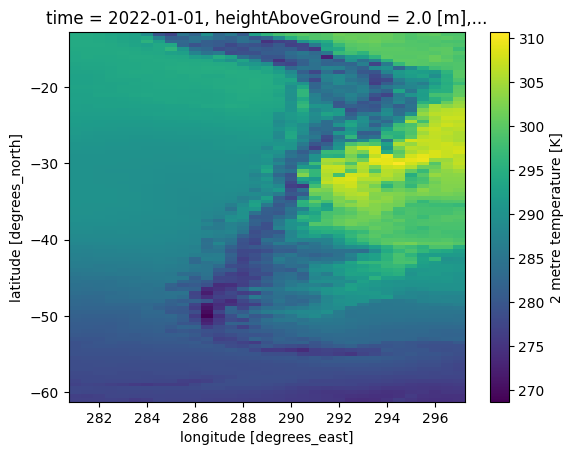

In [4]:
g05_t2m[0,:,:].plot()

Ejemplo archivo era5Land (target)  

|Datos|      | 
|-----|------|
| Año | 2022 | 
| Mes | 01   |  
| Día | 01   | 
| Fuente| [descarga](../Reproyeccion/ERA5_download.ipynb)| 

In [5]:
era5_og= xr.open_dataset("../Datos/ERA5/2022/era5_20220101.nc") 
era5_og

<xarray.Dataset>
Dimensions:    (longitude: 66, latitude: 194, time: 24)
Coordinates:
  * longitude  (longitude) float32 -79.12 -78.88 -78.62 ... -63.38 -63.12 -62.88
  * latitude   (latitude) float32 -12.88 -13.12 -13.38 ... -60.62 -60.88 -61.12
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-22 04:25:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [6]:
era5_t2m=era5_og['t2m']
era5_t2m

<xarray.DataArray 't2m' (time: 24, latitude: 194, longitude: 66)>
[307296 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -79.12 -78.88 -78.62 ... -63.38 -63.12 -62.88
  * latitude   (latitude) float32 -12.88 -13.12 -13.38 ... -60.62 -60.88 -61.12
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

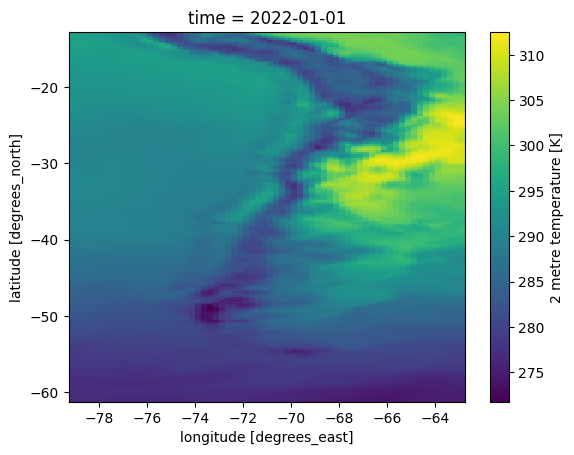

In [7]:
era5_t2m[0,:,:].plot()


### 2. Reproyección GFS: <div id='id2'>
**Problema**: Archivos GFS0.5 almacenados en el servidor y archivos ERA5 descargados no están en la misma grilla. <br>
**Solución**: Re-ajustar las grillas.

##### Visualización del problema:

In [8]:
print("Valores longitud GFS: \n", g05_og.longitude.values)
print("Valores longitud ERA5: \n", era5_og.longitude.values)

Valores longitud GFS: 
 [281.  281.5 282.  282.5 283.  283.5 284.  284.5 285.  285.5 286.  286.5
 287.  287.5 288.  288.5 289.  289.5 290.  290.5 291.  291.5 292.  292.5
 293.  293.5 294.  294.5 295.  295.5 296.  296.5 297. ]
Valores longitud ERA5: 
 [-79.125 -78.875 -78.625 -78.375 -78.125 -77.875 -77.625 -77.375 -77.125
 -76.875 -76.625 -76.375 -76.125 -75.875 -75.625 -75.375 -75.125 -74.875
 -74.625 -74.375 -74.125 -73.875 -73.625 -73.375 -73.125 -72.875 -72.625
 -72.375 -72.125 -71.875 -71.625 -71.375 -71.125 -70.875 -70.625 -70.375
 -70.125 -69.875 -69.625 -69.375 -69.125 -68.875 -68.625 -68.375 -68.125
 -67.875 -67.625 -67.375 -67.125 -66.875 -66.625 -66.375 -66.125 -65.875
 -65.625 -65.375 -65.125 -64.875 -64.625 -64.375 -64.125 -63.875 -63.625
 -63.375 -63.125 -62.875]


In [9]:
print("Valores latitud GFS [Khipu]: \n", g05_og.latitude.values)
print("Valores latitud ERA5 [Descargados]: \n", era5_og.latitude.values)

Valores latitud GFS [Khipu]: 
 [-13.  -13.5 -14.  -14.5 -15.  -15.5 -16.  -16.5 -17.  -17.5 -18.  -18.5
 -19.  -19.5 -20.  -20.5 -21.  -21.5 -22.  -22.5 -23.  -23.5 -24.  -24.5
 -25.  -25.5 -26.  -26.5 -27.  -27.5 -28.  -28.5 -29.  -29.5 -30.  -30.5
 -31.  -31.5 -32.  -32.5 -33.  -33.5 -34.  -34.5 -35.  -35.5 -36.  -36.5
 -37.  -37.5 -38.  -38.5 -39.  -39.5 -40.  -40.5 -41.  -41.5 -42.  -42.5
 -43.  -43.5 -44.  -44.5 -45.  -45.5 -46.  -46.5 -47.  -47.5 -48.  -48.5
 -49.  -49.5 -50.  -50.5 -51.  -51.5 -52.  -52.5 -53.  -53.5 -54.  -54.5
 -55.  -55.5 -56.  -56.5 -57.  -57.5 -58.  -58.5 -59.  -59.5 -60.  -60.5
 -61. ]
Valores latitud ERA5 [Descargados]: 
 [-12.875 -13.125 -13.375 -13.625 -13.875 -14.125 -14.375 -14.625 -14.875
 -15.125 -15.375 -15.625 -15.875 -16.125 -16.375 -16.625 -16.875 -17.125
 -17.375 -17.625 -17.875 -18.125 -18.375 -18.625 -18.875 -19.125 -19.375
 -19.625 -19.875 -20.125 -20.375 -20.625 -20.875 -21.125 -21.375 -21.625
 -21.875 -22.125 -22.375 -22.625 -22.875 -23.12

##### Visualización del proceso de reproyección: 

Un detalle importante es que la modificación de la data debe ser guardada en otro archivo. De lo contrario, debemos ejecutar el proceso de reproyección cada vez que se reinice el kernel.

In [11]:
#Estandarización de coordenadas
g05_re = xr.open_dataset("../Datos/GFS/2022/2022010100/GFS0.5_t2m_heightAboveGround_instant_2022010100.nc")
g05_re.coords['longitude'] = (g05_re.coords['longitude'] + 180) % 360 - 180
g05_re.rio.write_crs(4326)

<xarray.Dataset>
Dimensions:            (valid_time: 41, latitude: 97, longitude: 33)
Coordinates:
    time               datetime64[ns] ...
    heightAboveGround  float64 ...
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 -79.0 -78.5 -78.0 ... -63.5 -63.0
  * valid_time         (valid_time) datetime64[ns] 2022-01-01 ... 2022-01-06
    spatial_ref        int32 0
Data variables:
    t2m                (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2022-12-09T09:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [12]:
era5_re= xr.open_dataset("../Datos/ERA5/2022/era5_20220101.nc") 
#Ajuste de la grilla
era5_re=era5_re.sel(longitude=slice(-79, -63))
era5_re=era5_re.sel(latitude=slice(-13, -61))
era5_re.rio.write_crs(4326)

<xarray.Dataset>
Dimensions:      (longitude: 64, latitude: 192, time: 24)
Coordinates:
  * longitude    (longitude) float32 -78.88 -78.62 -78.38 ... -63.38 -63.12
  * latitude     (latitude) float32 -13.12 -13.38 -13.62 ... -60.62 -60.88
  * time         (time) datetime64[ns] 2022-01-01 ... 2022-01-01T23:00:00
    spatial_ref  int32 0
Data variables:
    u10          (time, latitude, longitude) float32 ...
    v10          (time, latitude, longitude) float32 ...
    d2m          (time, latitude, longitude) float32 ...
    t2m          (time, latitude, longitude) float32 ...
    sp           (time, latitude, longitude) float32 ...
    tp           (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-22 04:25:59 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

##### Comprobación de los cambios realizados:

In [13]:
print("Valores longitud GFS original [Khipu]: \n", g05_og.longitude.values)
print("Valores longitud GFS reproyectado [Rutina]: \n", g05_re.longitude.values)

Valores longitud GFS original [Khipu]: 
 [281.  281.5 282.  282.5 283.  283.5 284.  284.5 285.  285.5 286.  286.5
 287.  287.5 288.  288.5 289.  289.5 290.  290.5 291.  291.5 292.  292.5
 293.  293.5 294.  294.5 295.  295.5 296.  296.5 297. ]
Valores longitud GFS reproyectado [Rutina]: 
 [-79.  -78.5 -78.  -77.5 -77.  -76.5 -76.  -75.5 -75.  -74.5 -74.  -73.5
 -73.  -72.5 -72.  -71.5 -71.  -70.5 -70.  -69.5 -69.  -68.5 -68.  -67.5
 -67.  -66.5 -66.  -65.5 -65.  -64.5 -64.  -63.5 -63. ]


In [14]:
print("Valores latitud GFS original [Khipu]: \n", g05_og.latitude.values)
print("Valores latitud GFS reproyectado [Rutina]: \n", g05_re.latitude.values)

Valores latitud GFS original [Khipu]: 
 [-13.  -13.5 -14.  -14.5 -15.  -15.5 -16.  -16.5 -17.  -17.5 -18.  -18.5
 -19.  -19.5 -20.  -20.5 -21.  -21.5 -22.  -22.5 -23.  -23.5 -24.  -24.5
 -25.  -25.5 -26.  -26.5 -27.  -27.5 -28.  -28.5 -29.  -29.5 -30.  -30.5
 -31.  -31.5 -32.  -32.5 -33.  -33.5 -34.  -34.5 -35.  -35.5 -36.  -36.5
 -37.  -37.5 -38.  -38.5 -39.  -39.5 -40.  -40.5 -41.  -41.5 -42.  -42.5
 -43.  -43.5 -44.  -44.5 -45.  -45.5 -46.  -46.5 -47.  -47.5 -48.  -48.5
 -49.  -49.5 -50.  -50.5 -51.  -51.5 -52.  -52.5 -53.  -53.5 -54.  -54.5
 -55.  -55.5 -56.  -56.5 -57.  -57.5 -58.  -58.5 -59.  -59.5 -60.  -60.5
 -61. ]
Valores latitud GFS reproyectado [Rutina]: 
 [-13.  -13.5 -14.  -14.5 -15.  -15.5 -16.  -16.5 -17.  -17.5 -18.  -18.5
 -19.  -19.5 -20.  -20.5 -21.  -21.5 -22.  -22.5 -23.  -23.5 -24.  -24.5
 -25.  -25.5 -26.  -26.5 -27.  -27.5 -28.  -28.5 -29.  -29.5 -30.  -30.5
 -31.  -31.5 -32.  -32.5 -33.  -33.5 -34.  -34.5 -35.  -35.5 -36.  -36.5
 -37.  -37.5 -38.  -38.5 -39.  

### 3-. Preprocesamiento de los datos: <div id='id3'>
#### 3.1-. Importación de los datos: <div id='id4'>
Trabajaremos con tres tipos de datos distintos: 
- Archivos GFS 0.5 almacenados en el servidor Khipu
- Archivos Era5-Land descargados de la rutina especificada 
- Archivos DEM

Además, y únicamente para ejemplicar el proceso de preprocesamiento (de momento no estamos interesados en la calidad del resultado final, solo el camino hacia éste), trabajaremos los días pertenecientes a la estación de invierno (21 de junio al 23 de septiembre)

##### Importación de los datos GFS 0.5:

In [15]:
ruta_principal = "..\\Datos\\GFS\\2022"
rutas_gfs = []

for año in os.listdir(ruta_principal):
    ruta_año = os.path.join(ruta_principal, año)
    archivos_nc = glob.glob(os.path.join(ruta_año, "GFS0.5_t2m_heightAboveGround_instant_2022*.nc"))
    rutas_gfs.extend(archivos_nc)

print("Cantidad de archivos (días) importados: ",len(rutas_gfs))
print("Ejemplo de ruta de importación: \n", rutas_gfs[0])

Cantidad de archivos (días) importados:  364
Ejemplo de ruta de importación: 
 ..\Datos\GFS\2022\2022010100\GFS0.5_t2m_heightAboveGround_instant_2022010100.nc


##### Importación de los datos ERA5_land

In [16]:
ruta_principal = "..\\Datos\\ERA5\\2022"
rutas_era5 = []

for dia in os.listdir(ruta_principal):
    ruta_dia = os.path.join(ruta_principal, dia)
    rutas_era5.append(ruta_dia)

#Conflictos con la carpeta 29-11 de GFS, se elimina la carpeta respetiva en era5:
del rutas_era5[332] 

print("Cantidad de archivos (días) importados: ",len(rutas_era5))
print("Ejemplo de ruta de importación: \n", rutas_era5[0])

Cantidad de archivos (días) importados:  364
Ejemplo de ruta de importación: 
 ..\Datos\ERA5\2022\era5_20220101.nc


##### Reproyección de los archivos GFS: 

In [17]:
data_reproyectada="../Datos/GFS/2022_std/"

if os.path.exists(data_reproyectada):
    print("Archivos GFS ya reproyectados")

else:
    print("Comenzando reproyección...")
    os.mkdir("../Datos/GFS/2022_std")
    os.mkdir("../Datos/ERA5/2022_std")

    for ruta_gfs, ruta_era5 in zip(rutas_gfs,rutas_era5):

        g05 = xr.open_dataset(ruta_gfs) 
        g05.coords['longitude'] = (g05.coords['longitude'] + 180) % 360 - 180
        g05.rio.write_crs(4326)

        era5= xr.open_dataset(ruta_era5) 
        era5=era5.sel(longitude=slice(-79, -63))
        era5=era5.sel(latitude=slice(-13, -61))
        era5.rio.write_crs(4326)


        fechas = re.findall(r'\d+', ruta_gfs)

        g05.to_netcdf("..\\Datos\\GFS\\2022_std\\GFS0.5_t2m_heightAboveGround_instant_"+ fechas[-1]+"_std"+".nc")
        era5.to_netcdf("..\\Datos\\ERA5\\2022_std\\era5_"+fechas[-1][:-2]+"_std"+".nc")

        g05.close()
        era5.close()
        
    print("Reproyección finalizada correctamente")

Archivos GFS ya reproyectados


##### Importación de las nuevas rutas (reproyectadas)

In [18]:
ruta_principal = "..\\Datos\\GFS\\2022_std"
rutas_gfs_rep = []

for dia in os.listdir(ruta_principal):
    ruta_dia = os.path.join(ruta_principal, dia)
    rutas_gfs_rep.append(ruta_dia)

print("Cantidad de archivos (días) importados: ",len(rutas_gfs_rep))
print(rutas_gfs_rep[0])

Cantidad de archivos (días) importados:  364
..\Datos\GFS\2022_std\GFS0.5_t2m_heightAboveGround_instant_2022010100_std.nc


In [19]:
ruta_principal = "..\\Datos\\ERA5\\2022_std"
rutas_era5_rep = []

for dia in os.listdir(ruta_principal):
    ruta_dia = os.path.join(ruta_principal, dia)
    rutas_era5_rep.append(ruta_dia)

print("Cantidad de archivos (días) importados: ",len(rutas_era5_rep))
print(rutas_era5_rep[0])

Cantidad de archivos (días) importados:  364
..\Datos\ERA5\2022_std\era5_20220101_std.nc


#### 3.2 Cargado de valores:<div id='id5'> <div id='ex1'>

**Primera excepción:** Si bien estamos trabajando en un contexto donde la prioridad es mostrar el flujo de trabajo y no la calidad final del mismo, hay ciertas excepciones que deben ser atendidas debido a su importante relevancia en el planteamiento de ciertas funciones. La primera excepción tiene relación a cómo tratar los registros temporales asociados a los archivos GFS. Los archivos GFS contemplan registros temporales (cada 3 horas) no solo del propio día sino de 4 días posteriores, a diferencia de los archivos ERA5 que contemplan registros temporales (cada 1 hora) solamente del propio día:

In [20]:
gfs_ex_1=xr.open_dataset(rutas_gfs_rep[0])
gfs_ex_2=xr.open_dataset(rutas_gfs_rep[1])
era5_ex=xr.open_dataset(rutas_era5_rep[0])

print("Cantidad de registros temporales GFS: ", gfs_ex_1.valid_time.values.size)
print("GFS Mes: 01, día: 01: ", np.datetime_as_string(gfs_ex_1.valid_time.values[::8], unit='D'))
print("GFS Mes: 01, día: 02: ", np.datetime_as_string(gfs_ex_2.valid_time.values[::8], unit='D'))
print("Cantidad de registros temporales ERA5: ", era5_ex.time.values.size)
print("ERA5 Mes: 01, día: 01: ", np.datetime_as_string(era5_ex.time.values[::24], unit='D'))

Cantidad de registros temporales GFS:  41
GFS Mes: 01, día: 01:  ['2022-01-01' '2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05'
 '2022-01-06']
GFS Mes: 01, día: 02:  ['2022-01-02' '2022-01-03' '2022-01-04' '2022-01-05' '2022-01-06'
 '2022-01-07']
Cantidad de registros temporales ERA5:  24
ERA5 Mes: 01, día: 01:  ['2022-01-01']


El problema yace en que al momento de concatenar los archivos GFS, se irán solapando los días dando una cantidad de registros temporales muy superior a los archivos ERA5 concatenados:

In [21]:
gfs_concat = xr.open_mfdataset(rutas_gfs_rep, concat_dim='valid_time', combine='nested').valid_time.values.shape[0]
era5_concat = xr.open_mfdataset(rutas_era5_rep, concat_dim='valid_time', combine='nested').time.values.shape[0]
print("Dimensión valid_time GFS: ", gfs_concat)
print("Dimensión valid time ERA5: ", era5_concat)

c:\Users\LENOVO i7\Anaconda3\envs\SIVAR\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
c:\Users\LENOVO i7\Anaconda3\envs\SIVAR\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


Dimensión valid_time GFS:  14924
Dimensión valid time ERA5:  8736


Con el fin de continuar con el preprocesamiento de los archivos, se aplicará una solución temporal que consiste en importar los primeros 8 registros de cada archivo, de esta manera se evitará el solapamiento de los registros temporales al mismo tiempo que se cubren los días necesarios:

In [27]:
datos_seleccionados = []

winter_gfs = rutas_gfs_rep[171:266]
for ruta in winter_gfs: #estación de invierno
    ds = xr.open_mfdataset(ruta)
    primeros_8_registros = ds.isel(valid_time=slice(0, 8))
    datos_seleccionados.append(primeros_8_registros)
    ds.close()

print("Primer archivo importado: ", winter_gfs[0])
print("Último archivo importado: ", winter_gfs[-1])
print("Cantidad de días importados: ", len(winter_gfs))
gfs_val = xr.concat(datos_seleccionados, dim='valid_time')
gfs_t2m_val=gfs_val['t2m']
gfs_t2m_val

Primer archivo importado:  ..\Datos\GFS\2022_std\GFS0.5_t2m_heightAboveGround_instant_2022062100_std.nc
Último archivo importado:  ..\Datos\GFS\2022_std\GFS0.5_t2m_heightAboveGround_instant_2022092300_std.nc
Cantidad de días importados:  95


c:\Users\LENOVO i7\Anaconda3\envs\SIVAR\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.DataArray 't2m' (valid_time: 760, latitude: 97, longitude: 33)>
dask.array<concatenate, shape=(760, 97, 33), dtype=float32, chunksize=(8, 97, 33), chunktype=numpy.ndarray>
Coordinates:
    time               (valid_time) datetime64[ns] 2022-06-21 ... 2022-09-23
    heightAboveGround  float64 2.0
  * latitude           (latitude) float64 -13.0 -13.5 -14.0 ... -60.5 -61.0
  * longitude          (longitude) float64 -79.0 -78.5 -78.0 ... -63.5 -63.0
  * valid_time         (valid_time) datetime64[ns] 2022-06-21 ... 2022-09-23T...
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

In [29]:
winter_era5= rutas_era5_rep[171:266]
print("Primer archivo importado: ", winter_era5[0])
print("Último archivo importado: ", winter_era5[-1])
print("Cantidad de días importados: ", len(winter_era5))
era5_valores = xr.open_mfdataset(winter_era5, concat_dim='time', combine='nested') #estación de invierno
era5_valores = era5_valores.rename( {'time':'valid_time'})
era5_t2m_val= era5_valores['t2m'][::3,:,:]
era5_t2m_val

Primer archivo importado:  ..\Datos\ERA5\2022_std\era5_20220621_std.nc
Último archivo importado:  ..\Datos\ERA5\2022_std\era5_20220923_std.nc
Cantidad de días importados:  95


c:\Users\LENOVO i7\Anaconda3\envs\SIVAR\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.DataArray 't2m' (valid_time: 760, latitude: 192, longitude: 64)>
dask.array<getitem, shape=(760, 192, 64), dtype=float32, chunksize=(8, 192, 64), chunktype=numpy.ndarray>
Coordinates:
  * longitude   (longitude) float32 -78.88 -78.62 -78.38 ... -63.38 -63.12
  * latitude    (latitude) float32 -13.12 -13.38 -13.62 ... -60.38 -60.62 -60.88
  * valid_time  (valid_time) datetime64[ns] 2022-06-21 ... 2022-09-23T21:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

#### 3.3 Estandarización de dimensiones:<div id='id6'>

In [30]:
method = 'nearest'
g05_final = gfs_t2m_val.interp_like(era5_t2m_val, method=method)
print("Antiguas dimensiones de la pila GFS: ", gfs_t2m_val.shape)
print("Nuevas dimensiones de la pila GFS: ",g05_final.shape)
print("Dimensiones de la pila ERA5: ", era5_t2m_val.shape)

Antiguas dimensiones de la pila GFS:  (760, 97, 33)
Nuevas dimensiones de la pila GFS:  (760, 192, 64)
Dimensiones de la pila ERA5:  (760, 192, 64)


#### 3.4 Extracción de parches: <div id='id7'>

Se atenderá manualmente la extracción de los parches  con tal de no depender tanto de los métodos de tensorflow y así  facilitarla reconstrucción de los parches. Lo primero será atendener la estructura de la función a utilizar:

```
def extraccion_parches():
    for t in range(0,38): 
        for dlat in range(0,401 - 32,32):
            for dlong in range(0,101 - 32,32):
                extraer_parche= variable[ [t, t+1, t+2] , dlat:(dlat+32), dlong:(dlong+32)]
                -Almacenar_parche-               
```

El tamaño de los parches debe ser de $(3,32,32)$, donde la primera variable representará los cortes en el tiempo (cada 3 tiempos con sucesión de 1, atendido por el primer ciclo for), la segunda variable representará el tamaño de los cortes en la latitud (segundo ciclo for), y la tercera variable representará la longitud (tercer ciclo for). Ahora bien, la cantidad de parches esperada será: <br><br>
$ \text{latitud} \rightarrow 192 // 32 = 6 \\
\text{longitude} \rightarrow 64 // 32 = 2 \\
\text{valid time} \rightarrow 760: \text{(bloques de 3 con sucesión de 1)}: \# \lbrace (1,2,3), (2,3,4), ... , (757,758,759),(758,759,760) \rbrace = 758$

Cantidad de parches: $6 \cdot 2 \cdot 758= 9096$

Aplicación del método:

In [31]:
def extraccion_parches(Var, dx=32):

        '''Extrae parches de tamaño (3,32,32) y retorna el stack con todos los parches
    input:
        Var: [DataArray] Datarray retornado por getVar() de tamaño (40,401,101)
    return:
        stack: [tf tensor] Stack con los parches, stack.shape=(1368, 3, 32, 32)
        '''
    
        stack = tf.stack([],axis=0)
        dim_t= Var.shape[0]
        dim_lat= Var.shape[1]
        dim_lon= Var.shape[2]

        #recorremos en el tiempo
        for dt in tqdm(range(0,dim_t -2)):
            #recorremos en la latitude
            for dlat in range(0,dim_lat,dx):
                #recorremos en la longitude
                for dlong in range(0,dim_lon,dx):  
                    #Cortamos parches de 32x32 en 3 tiempos             
                    parche=Var[ dt:(dt+3), dlat:(dlat+dx), dlong:(dlong+dx)]

                    #si el stack no está vacío, concatenamos los parches
                    if tf.equal(tf.size(stack), 0) == False:
                        parche = tf.expand_dims(parche, axis=0)
                        stack= tf.concat((stack, parche), axis=0)
                        #y pasamos a la siguiente iteración
                        continue
                
                    #si el stack está vacío, lo inicializamos
                    stack=tf.stack([parche],axis=0)
        patches = tf.expand_dims(stack, 4) 
        print("Stack patches shape: ",patches.shape)               
        return patches

##### 3.4.1 GFS y ERA5 <div id='id8'>

Guardado de parches:

In [32]:
def guardado_parches(parches, nombre_parches, carpeta, opcional='', verbose=False):
    ruta_completa = os.path.join(carpeta, nombre_parches + opcional + '.npy')
    np.save(ruta_completa, parches)
    if verbose:
        print("Parches guardados exitosamente en: ", ruta_completa)

#Id guardado según intervalo de fechas
primer_dia=re.findall(r'\d+', winter_gfs[0])[-1] 
ultimo_dia=re.findall(r'\d+', winter_gfs[-1])[-1] 
intervalo= primer_dia + "_" + ultimo_dia
print(intervalo)

2022062100_2022092300


In [33]:
%%time
nombre_gfs_parches='parches/gfs_' + intervalo + '.npy'

if  os.path.exists(nombre_gfs_parches):
    gfs_parches   = tf.convert_to_tensor(np.load(nombre_gfs_parches))
    print(f"Parche: {nombre_gfs_parches} importados exitosamente")

else: 
    gfs_parches= extraccion_parches(g05_final)
    guardado_parches(gfs_parches,'gfs_'+ intervalo,'parches',verbose=True)

100%|██████████| 758/758 [30:02<00:00,  2.38s/it]

Stack patches shape:  (9096, 3, 32, 32, 1)
Parches guardados exitosamente en:  parches\gfs_2022062100_2022092300.npy
CPU times: total: 10min 27s
Wall time: 30min 2s


In [34]:
%%time
nombre_era5_parches='parches/era5_' + intervalo + '.npy'

if  os.path.exists(nombre_era5_parches):
    era5_parches   = tf.convert_to_tensor(np.load(nombre_era5_parches))
    print(f"Parche: {nombre_era5_parches} importados exitosamente")

else: 
    era5_parches= extraccion_parches(era5_t2m_val)
    guardado_parches(era5_parches,'era5_'+ intervalo,'parches',verbose=True)

100%|██████████| 758/758 [02:46<00:00,  4.56it/s]

Stack patches shape:  (9096, 3, 32, 32, 1)
Parches guardados exitosamente en:  parches\era5_2022062100_2022092300.npy
CPU times: total: 1min 35s
Wall time: 2min 46s


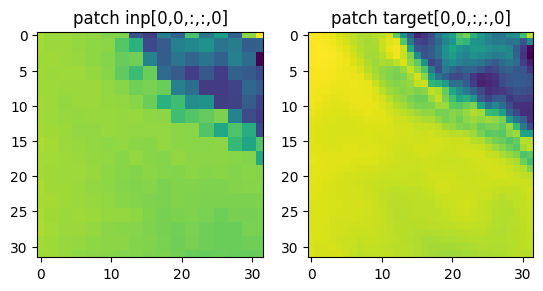

In [35]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
fig, axis = plt.subplots(1, 2)
axis[ 0].imshow( tf.squeeze( gfs_parches[0,0,:,:,0]  ) )
axis[ 0].set_title("patch inp[0,0,:,:,0]")

axis[ 1].imshow( tf.squeeze( era5_parches[0,0,:,:,0]  ) )
axis[ 1].set_title("patch target[0,0,:,:,0]")
plt.show()

##### 3.4.2 Data DEM: <div id='id9'>

In [36]:
dem=xr.open_mfdataset("../Datos/dem/DEM_rep.nc", concat_dim='time', combine='nested')
dem_band1_val= dem['Band1']
dem_band1_val

c:\Users\LENOVO i7\Anaconda3\envs\SIVAR\lib\site-packages\xarray\core\concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.DataArray 'Band1' (time: 1, lat: 192, lon: 64)>
dask.array<broadcast_to, shape=(1, 192, 64), dtype=float32, chunksize=(1, 192, 64), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -60.88 -60.62 -60.38 -60.12 ... -13.62 -13.38 -13.12
  * lon      (lon) float64 -78.88 -78.62 -78.38 -78.12 ... -63.62 -63.38 -63.12
Dimensions without coordinates: time
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

In [37]:
dem_band1_val.interp_like(era5_t2m_val, method=method)
dem_band1_val

<xarray.DataArray 'Band1' (time: 1, lat: 192, lon: 64)>
dask.array<broadcast_to, shape=(1, 192, 64), dtype=float32, chunksize=(1, 192, 64), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -60.88 -60.62 -60.38 -60.12 ... -13.62 -13.38 -13.12
  * lon      (lon) float64 -78.88 -78.62 -78.38 -78.12 ... -63.62 -63.38 -63.12
Dimensions without coordinates: time
Attributes:
    long_name:     GDAL Band Number 1
    grid_mapping:  crs

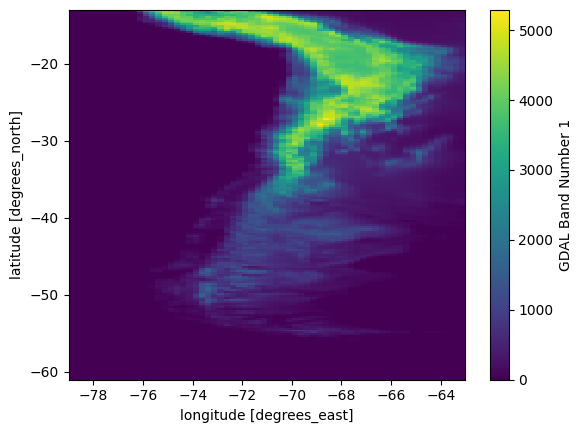

In [38]:
dem_band1_val[0,:,:].plot()

In [39]:
dim_time=era5_t2m_val.shape[0]
band1_stacked=tf.repeat(dem_band1_val.values, dim_time, axis=0)
print("var dem shape: ", band1_stacked.shape)

var dem shape:  (760, 192, 64)


In [40]:
%%time

nombre_band1_parches='parches/orog_' + intervalo + '.npy'

if  os.path.exists(nombre_band1_parches):
    band1_parches   = tf.convert_to_tensor(np.load(nombre_band1_parches))
    print(f"Parche: {nombre_band1_parches} importados exitosamente")

else: 
    band1_parches= extraccion_parches(band1_stacked)
    guardado_parches(band1_parches,'orog_'+ intervalo,'parches',verbose=True)

100%|██████████| 758/758 [01:58<00:00,  6.38it/s]

Stack patches shape:  (9096, 3, 32, 32, 1)
Parches guardados exitosamente en:  parches\orog_2022062100_2022092300.npy
CPU times: total: 1min 31s
Wall time: 1min 59s


##### 3.4.3 Parches Latitud: <div id='id10'>

In [41]:
ll = tf.constant(era5_t2m_val.latitude.values)
vv = era5_t2m_val.values.shape
lat = tf.transpose(tf.broadcast_to(ll, [vv[0], vv[2], vv[1]]), perm=(0, 2, 1))

In [42]:
%%time
nombre_lat_parches='parches/lat_' + intervalo + '.npy'

if  os.path.exists(nombre_lat_parches):
    lat_parches   = tf.convert_to_tensor(np.load(nombre_lat_parches))
    print(f"Parche: {nombre_lat_parches} importados exitosamente")

else: 
    lat_parches= extraccion_parches(lat)
    guardado_parches(lat_parches,'lat_'+ intervalo,'parches',verbose=True)

100%|██████████| 758/758 [01:56<00:00,  6.48it/s]

Stack patches shape:  (9096, 3, 32, 32, 1)
Parches guardados exitosamente en:  parches\lat_2022062100_2022092300.npy
CPU times: total: 1min 29s
Wall time: 1min 57s


##### 3.4.4 Parches Longitud <div id='id11'>

In [43]:
ll = tf.constant(era5_t2m_val.longitude.values)
vv = era5_t2m_val.values.shape         
lon = tf.broadcast_to(ll, vv)

In [54]:
%%time
nombre_lon_parches='parches/lon_' + intervalo + '.npy'

if  os.path.exists(nombre_lon_parches):
    long_parches   = tf.convert_to_tensor(np.load(nombre_lon_parches))
    print(f"Parche: {nombre_lon_parches} importados exitosamente")

else: 
    long_parches= extraccion_parches(lon)
    guardado_parches(lon_parches,'lon_'+ intervalo,'parches',verbose=True)

100%|██████████| 758/758 [01:57<00:00,  6.43it/s]

Stack patches shape:  (9096, 3, 32, 32, 1)
Parches guardados exitosamente en:  parches\lon_2022062100_2022092300.npy
CPU times: total: 1min 12s
Wall time: 1min 58s


##### 3.4.5 Parches Time: <div id='id12'>

In [45]:
val_tiempos=era5_t2m_val.valid_time
val_tiempos

<xarray.DataArray 'valid_time' (valid_time: 760)>
array(['2022-06-21T00:00:00.000000000', '2022-06-21T03:00:00.000000000',
       '2022-06-21T06:00:00.000000000', ..., '2022-09-23T15:00:00.000000000',
       '2022-09-23T18:00:00.000000000', '2022-09-23T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2022-06-21 ... 2022-09-23T21:00:00
Attributes:
    long_name:  time

In [46]:
print("Primera fecha registada: \n",val_tiempos[0].valid_time)

Primera fecha registada: 
 <xarray.DataArray 'valid_time' ()>
array('2022-06-21T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    valid_time  datetime64[ns] 2022-06-21
Attributes:
    long_name:  time


In [47]:
print("Primer día del año: \n",val_tiempos[0].astype('M8[Y]'))

Primer día del año: 
 <xarray.DataArray 'valid_time' ()>
array('2022-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    valid_time  datetime64[ns] 2022-06-21
Attributes:
    long_name:  time


C:\Users\LENOVO i7\AppData\Local\Temp\ipykernel_7284\3718406727.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  print("Primer día del año: \n",val_tiempos[0].astype('M8[Y]'))


In [48]:
diff_ns = (val_tiempos[0]-val_tiempos[0].astype('M8[Y]')).astype(float) 
diff_ns

C:\Users\LENOVO i7\AppData\Local\Temp\ipykernel_7284\3301043910.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  diff_ns = (val_tiempos[0]-val_tiempos[0].astype('M8[Y]')).astype(float)


<xarray.DataArray 'valid_time' ()>
array(1.47744e+16)
Coordinates:
    valid_time  datetime64[ns] 2022-06-21

In [49]:
diff_tiempo = (val_tiempos-val_tiempos.astype('M8[Y]')).astype(float) 
diff_tiempo_tensor = tf.constant(diff_tiempo)
print("diff_tiempo_tensor shape: ",diff_tiempo_tensor.shape)
diff_tiempo_tensor[:10]

diff_tiempo_tensor shape:  (760,)


C:\Users\LENOVO i7\AppData\Local\Temp\ipykernel_7284\3109788549.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  diff_tiempo = (val_tiempos-val_tiempos.astype('M8[Y]')).astype(float)


<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([1.47744e+16, 1.47852e+16, 1.47960e+16, 1.48068e+16, 1.48176e+16,
       1.48284e+16, 1.48392e+16, 1.48500e+16, 1.48608e+16, 1.48716e+16])>

In [50]:
dim_darray = era5_t2m_val.values.shape 
time = tf.transpose(tf.broadcast_to(diff_tiempo_tensor, [dim_darray[1], dim_darray[2], dim_darray[0]]), perm=(2,0,1))
print("time shape: ",time.shape)

time shape:  (760, 192, 64)


In [51]:
%%time

nombre_time2_parches='parches/time2_' + intervalo + '.npy'

if  os.path.exists(nombre_time2_parches):
    time2  = tf.convert_to_tensor(np.load(nombre_time2_parches))
    print(f"Parche: {nombre_time2_parches} importados exitosamente")

else: 
    time2= extraccion_parches(time, dx=4)
    guardado_parches(time2,'time2_'+ intervalo,'parches',verbose=True)
print("time2 shape: ",time2.shape)

100%|██████████| 758/758 [3:35:35<00:00, 17.07s/it]  


Stack patches shape:  (582144, 3, 4, 4, 1)
Parches guardados exitosamente en:  parches\time2_2022062100_2022092300.npy
time2 shape:  (582144, 3, 4, 4, 1)
CPU times: total: 3h 37min 11s
Wall time: 3h 35min 36s


In [52]:
%%time

nombre_time1_parches='parches/time1_' + intervalo + '.npy'

if  os.path.exists(nombre_time1_parches):
    time1_parches  = tf.convert_to_tensor(np.load(nombre_time1_parches))
    print(f"Parche: {nombre_time1_parches} importados exitosamente")

else: 
    time1_parches= extraccion_parches(time)
    guardado_parches(time1_parches,'time1_'+ intervalo,'parches',verbose=True)
print("time1 shape: ",time1_parches.shape)

100%|██████████| 758/758 [03:54<00:00,  3.23it/s]

Stack patches shape:  (9096, 3, 32, 32, 1)
Parches guardados exitosamente en:  parches\time1_2022062100_2022092300.npy
time1 shape:  (9096, 3, 32, 32, 1)
CPU times: total: 2min 44s
Wall time: 3min 54s


##### 3.4.6 Resumen Parches <div id='id13'>

In [55]:
print("gfs: ",gfs_parches.shape)
print("era5: ",era5_parches.shape)
print("lat: ",lat_parches.shape)
print("long: ",long_parches.shape)
print("orog: ",band1_parches.shape)
print("time1: ",time1_parches.shape) #stride 32
print("time2: ",time2.shape) #stride 4

gfs:  (9096, 3, 32, 32, 1)
era5:  (9096, 3, 32, 32, 1)
lat:  (9096, 3, 32, 32, 1)
long:  (9096, 3, 32, 32, 1)
orog:  (9096, 3, 32, 32, 1)
time1:  (9096, 3, 32, 32, 1)
time2:  (582144, 3, 4, 4, 1)


#### 3.5 Normalización: <div id='id14'>

In [56]:
def normalization( data_in=input,inverse=False, scale_factor=[1,1]):
    '''
        :param data_in: variable a normalizar
        :param inverse: True en caso de devolver la transformación
        :return: variable normalizada
    '''
    if not inverse:
        scale_factor_ = np.max(np.abs(data_in))
        scale_factor_2 = np.min(np.abs(data_in))
        data_out = (data_in-scale_factor_2)/(scale_factor_ - scale_factor_2)
        scale_factor_ = [scale_factor_,scale_factor_2]
    else:
        data_out=(data_in * (scale_factor[0]-scale_factor[1]))+scale_factor[1]
        scale_factor_ = scale_factor
    return data_out, scale_factor_

In [57]:
gfs_norm, scale_factor_target = normalization(gfs_parches)
era5_norm, scale_factor_inp = normalization(era5_parches)
lat_norm, scale_factor_lat = normalization(lat_parches)
lon_norm, scale_factor_lon = normalization(long_parches)
orog_norm, scale_factor_orog = normalization(band1_parches)
time_norm, scale_factor_time = normalization(time1_parches)

#### 3.6 Revisión de parches<div id='id15'>

In [58]:
def cantidad_nan(inputs=[]):
    '''Recorre cada variable que conforma el input de la red, y cuenta los valores nan de cada uno.
    inputs:
        inputs: [List] Lista con los inputs de la red.
    '''
    inputs_name=["era5","gfs","lat","lot","orog","time1","time2"]
    cantidad=[];cont=0

    for inp in inputs:
        check_nan= tf.math.is_nan(inp[:,0,:,:,0])
        cont=np.sum(check_nan)
        cantidad.append(cont)

    for nombre,num in zip(inputs_name,cantidad):
        print(f"{nombre}- num valores nan: {num}")


cantidad_nan(inputs=[era5_parches,gfs_parches,lat_parches,long_parches,band1_parches,time1_parches,time2])

era5- num valores nan: 0
gfs- num valores nan: 0
lat- num valores nan: 0
lot- num valores nan: 0
orog- num valores nan: 0
time1- num valores nan: 0
time2- num valores nan: 0


#### 3.7 División de la data<div id='id16'>

In [59]:
def mysplit(inp, time, orog, lat, lon, target):
        data = tf.concat([tf.cast(inp, dtype=tf.float32),
                      tf.cast(time, dtype=tf.float32),
                      tf.cast(orog, dtype=tf.float32),
                      tf.cast(lat, dtype=tf.float32),
                      tf.cast(lon, dtype=tf.float32),
                      tf.cast(target, dtype=tf.float32)], axis=4)
        data = tf.random.shuffle(data, seed=10)
        n = data.shape[0]
        n_train = int(n * .6)
        n_valid = int(n * .2)
        n_test = n - n_train - n_valid
        data = tf.split(data, [n_train, n_valid, n_test])
        return (tf.expand_dims(data[0][:, :, :, :, 0],4),
            tf.expand_dims(data[0][:, :, :, :, 1],4),
            tf.expand_dims(data[0][:, :, :, :, 2],4),
            tf.expand_dims(data[0][:, :, :, :, 3],4),
            tf.expand_dims(data[0][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[0][:,1,:,:,5],1),4),
            tf.expand_dims(data[1][:, :, :, :, 0],4),
            tf.expand_dims(data[1][:, :, :, :, 1],4),
            tf.expand_dims(data[1][:, :, :, :, 2],4),
            tf.expand_dims(data[1][:, :, :, :, 3],4),
            tf.expand_dims(data[1][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[1][:,1,:,:,5],1),4),
            tf.expand_dims(data[2][:, :, :, :, 0],4),
            tf.expand_dims(data[2][:, :, :, :, 1],4),
            tf.expand_dims(data[2][:, :, :, :, 2],4),
            tf.expand_dims(data[2][:, :, :, :, 3],4),
            tf.expand_dims(data[2][:, :, :, :, 4],4),
            tf.expand_dims(tf.expand_dims(data[2][:,1,:,:,5],1),4))

In [60]:
(inp_tr,time_tr,orog_tr,lat_tr,lon_tr,target_tr,
 inp_va,time_va,orog_va,lat_va,lon_va,target_va,
 inp_te,time_te, orog_te,lat_te,lon_te, target_te) = mysplit(gfs_norm,time_norm,orog_norm,lat_norm,lon_norm,era5_norm)

##### Resumen división de la data:

In [61]:
print("#"*10+" "+"Entrenamiento"+" "+"#"*10)
print("target: ",target_tr.shape)
print("inp: ",inp_tr.shape)
print("lat: ",lat_tr.shape)
print("long: ",lon_tr.shape)
print("orog: ",orog_tr.shape)
print("time1: ",time_tr.shape)

########## Entrenamiento ##########
target:  (5457, 1, 32, 32, 1)
inp:  (5457, 3, 32, 32, 1)
lat:  (5457, 3, 32, 32, 1)
long:  (5457, 3, 32, 32, 1)
orog:  (5457, 3, 32, 32, 1)
time1:  (5457, 3, 32, 32, 1)


In [62]:
print("#"*10+" "+"Validación"+" "+"#"*10)
print("target: ",target_va.shape)
print("inp: ",inp_va.shape)
print("lat: ",lat_va.shape)
print("long: ",lon_va.shape)
print("orog: ",orog_va.shape)
print("time1: ",time_va.shape)

########## Validación ##########
target:  (1819, 1, 32, 32, 1)
inp:  (1819, 3, 32, 32, 1)
lat:  (1819, 3, 32, 32, 1)
long:  (1819, 3, 32, 32, 1)
orog:  (1819, 3, 32, 32, 1)
time1:  (1819, 3, 32, 32, 1)


In [63]:
print("#"*10+" "+"Testeo"+" "+"#"*10)
print("target: ",target_te.shape)
print("inp: ",inp_te.shape)
print("lat: ",lat_te.shape)
print("long: ",lon_te.shape)
print("orog: ",orog_te.shape)
print("time1: ",time_te.shape)

########## Testeo ##########
target:  (1820, 1, 32, 32, 1)
inp:  (1820, 3, 32, 32, 1)
lat:  (1820, 3, 32, 32, 1)
long:  (1820, 3, 32, 32, 1)
orog:  (1820, 3, 32, 32, 1)
time1:  (1820, 3, 32, 32, 1)


#### 3.8 Ajuste de time:<div id='id17'> <div id='ex3'>

**Excepción 3:** Simplemente desconozco qué pasa con la variable *time*

In [64]:
time2_cut=time2[:era5_norm.shape[0]]
print("shape time 2 antes del corte: ", time2.shape)
print("shape  time 2 después del corte:  ",time2_cut.shape)
time_norm, scale_factor_time=normalization(time2_cut)

#para el entreno:
time2_tr =time_norm[:inp_tr.shape[0]]
print("inp_tr.shape[0]: ", inp_tr.shape[0])
print("time2_tr shape: ", time2_tr.shape)

#para la validación:
time2_va = time_norm[inp_tr.shape[0]:inp_tr.shape[0]+inp_va.shape[0]]
print(f"(inp_tr.shape[0]) {inp_tr.shape[0]} + (inp_va.shape[0]) {inp_va.shape[0]} = {inp_tr.shape[0]+inp_va.shape[0]}")
print("time2_va shape: ", time2_va.shape)

#para testeo:
time2_te = time_norm[inp_tr.shape[0]+inp_va.shape[0]:era5_norm.shape[0]]
print("inp_norm.shape[0]: ", era5_norm.shape[0])
print("time2_te shape: ", time2_te.shape)

shape time 2 antes del corte:  (582144, 3, 4, 4, 1)
shape  time 2 después del corte:   (9096, 3, 4, 4, 1)
inp_tr.shape[0]:  5457
time2_tr shape:  (5457, 3, 4, 4, 1)
(inp_tr.shape[0]) 5457 + (inp_va.shape[0]) 1819 = 7276
time2_va shape:  (1819, 3, 4, 4, 1)
inp_norm.shape[0]:  9096
time2_te shape:  (1820, 3, 4, 4, 1)


#### 4-. Entrenamiento U-net:<div id='id18'>

In [65]:
import Model as cnn
model_grad_loss = cnn.get_model()
model_grad_loss.summary()

2.11.0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 32, 32,   0           []                               
                                1)]                                                               
                                                                                                  
 conv3d (Conv3D)                (None, 3, 32, 32, 7  5472        ['input_1[0][0]']                
                                2)                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 3, 32, 32,   0           []                               
                                1)]                                                    

In [66]:
from Model import grad_loss 
from keras.models import load_model
import pickle 

tf.config.run_functions_eagerly(True)

if os.path.exists('red'):
    nombre_red= "red/red_"+ intervalo + ".h5"
    grad_loss = load_model(nombre_red, custom_objects={'grad_loss': grad_loss})
    print("Red importada exitosamente desde: ",nombre_red )

else: 
    os.mkdir("red")
    grad_loss=model_grad_loss.fit([inp_tr,time2_tr,lat_tr,lon_tr,orog_tr], target_tr, epochs=2,
            validation_data=([inp_va,time2_va,lat_va,lon_va,orog_va], target_va))
    nombre_red = "red/red_"+ intervalo + ".h5"
    model_grad_loss.save(nombre_red)
    print("Red guardada exitosamente en: ", nombre_red)

    entrenamiento_red= "red/historial_entrenamiento_"+ intervalo + ".pkl"
    with open(entrenamiento_red, 'wb') as archivo:
        pickle.dump(grad_loss.history, archivo) 
        print("Entrenamiento de la red guardado exitosamente en: ", entrenamiento_red)

Epoch 1/2


c:\Users\LENOVO i7\Anaconda3\envs\SIVAR\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


171/171 [==============================] - 7948s 46s/step - loss: 4.0772 - mse: 2587.7573 - mae: 3.5483 - mape: 732.6172 - val_loss: 0.0599 - val_mse: 0.0030 - val_mae: 0.0458 - val_mape: 9.3736
Epoch 2/2
171/171 [==============================] - 7904s 46s/step - loss: 0.0429 - mse: 0.0016 - mae: 0.0296 - mape: 57.9003 - val_loss: 0.0298 - val_mse: 7.3492e-04 - val_mae: 0.0173 - val_mape: 3.6304
Red guardada exitosamente en:  red/red_2022062100_2022092300.h5
Entrenamiento de la red guardado exitosamente en:  red/historial_entrenamiento_2022062100_2022092300.pkl


In [71]:
i=0
observed = normalization(data_in=tf.squeeze(target_te[i,0,:,:,0]),
                         inverse=True,
                         scale_factor=scale_factor_target)[0]

input_plot = normalization(data_in=tf.squeeze(inp_te[i,0,:,:,0]),
                         inverse=True,
                         scale_factor=scale_factor_inp)[0]

In [70]:
def output_plot(input_plot,observed,fore):
    residuals = observed - fore
    params = {'axes.titlesize':'9',
              'xtick.labelsize':'9',
              'ytick.labelsize':'9',
              'figure.figsize': (20,20),
              'figure.dpi': 200
              }
    #plt.figure(figsize=[16,16])
    plt.style.use('ggplot')
    plt.rcParams.update(params)

    i=0
    plt.subplot(141) #131
    p1 = plt.imshow(fore, vmin = np.min([fore,observed]), vmax = np.max([fore,observed]))
    plt.colorbar(orientation="vertical",fraction=0.047, pad=0.01)
    plt.title('forecasted')

    plt.subplot(142) #132
    plt.imshow(residuals, vmin = np.min(residuals), vmax = np.max(residuals))
    plt.colorbar(orientation="vertical", fraction=0.047, pad=0.01)
    plt.title('residuals')


    plt.subplot(143) #132
    plt.imshow(observed, vmin = np.min([fore,observed]), vmax = np.max([fore,observed]))
    plt.colorbar(orientation="vertical",fraction=0.047, pad=0.01)
    plt.title('testing target')

    plt.subplot(144)
    p1 = plt.imshow(input_plot,
                    vmin = np.min([input_plot]),
                    vmax = np.max([input_plot]))
    plt.colorbar(orientation="vertical",fraction=0.047, pad=0.01)
    plt.title('input te')

    plt.savefig('grad_loss.png')
    plt.show()

In [72]:
t = model_grad_loss.call([inp_te[:12],time2_te[:12],lat_te[:12],lon_te[:12],orog_te[:12]], target_te[:12])

fore = normalization(data_in=tf.squeeze(t[0,0,:,:,0]),
                     inverse=True,
                     scale_factor=scale_factor_target)[0]

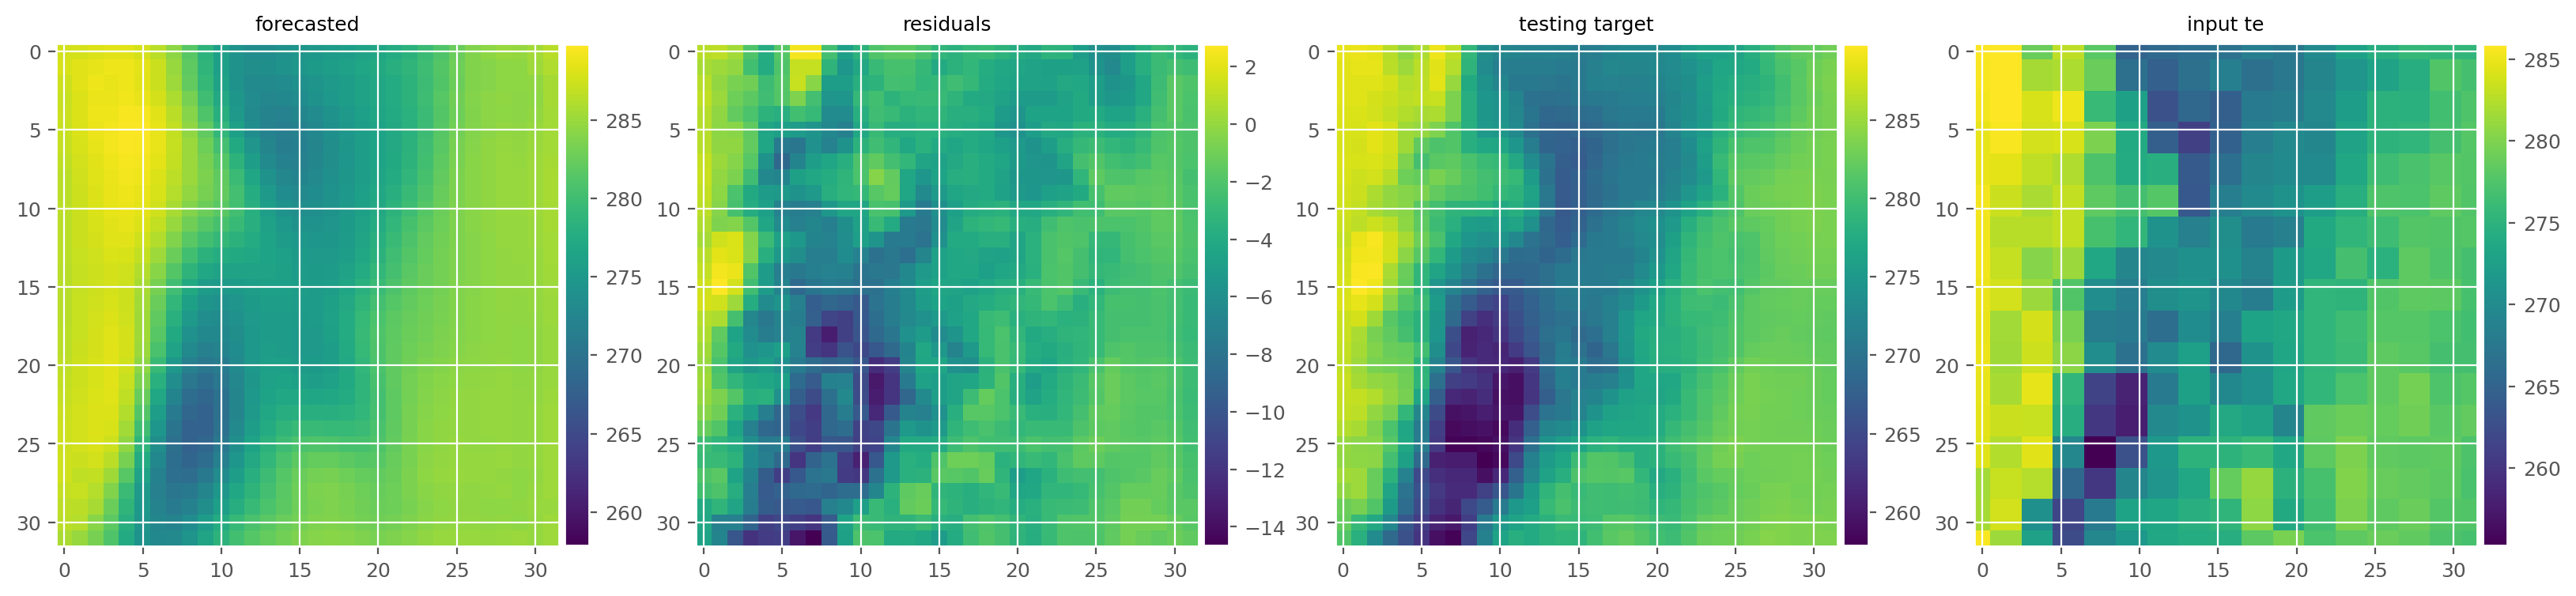

In [73]:
output_plot(input_plot,observed,fore)